In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')#in time series, we set date , to index
df.index = pd.to_datetime(df.index)

In [4]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [5]:
df.tail() # from 2002 to 2018

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


<Axes: title={'center': 'Energy Use in MW'}, xlabel='Datetime'>

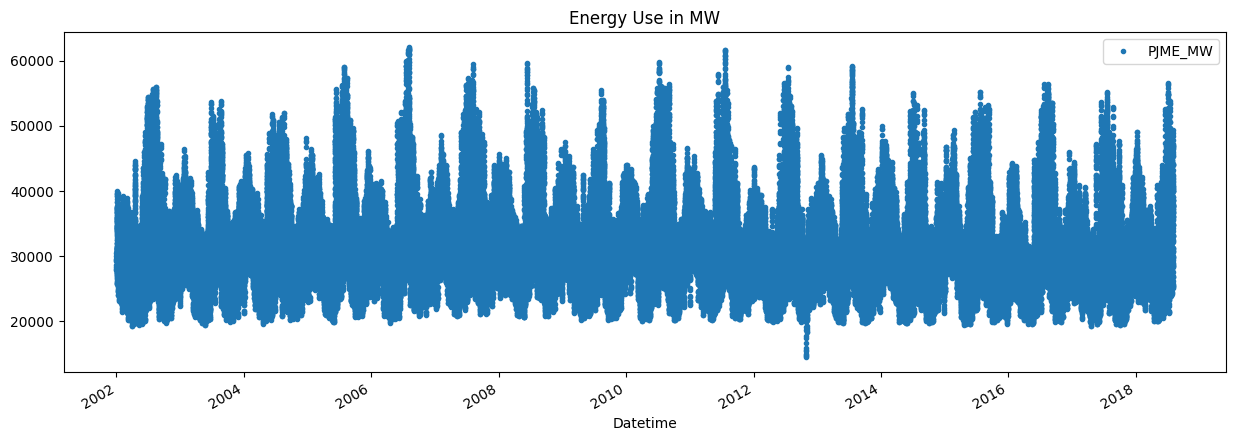

In [6]:
df.plot(style='.', figsize=(15,5), title='Energy Use in MW')

In [8]:
df.index # change from object to date time
#df.index = pd.to_datetime(df.index)

#now chart IN , proper x axis , time by year 


DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

# Train / Test Split

In [ ]:
#2015 split [ prior 15 is training]

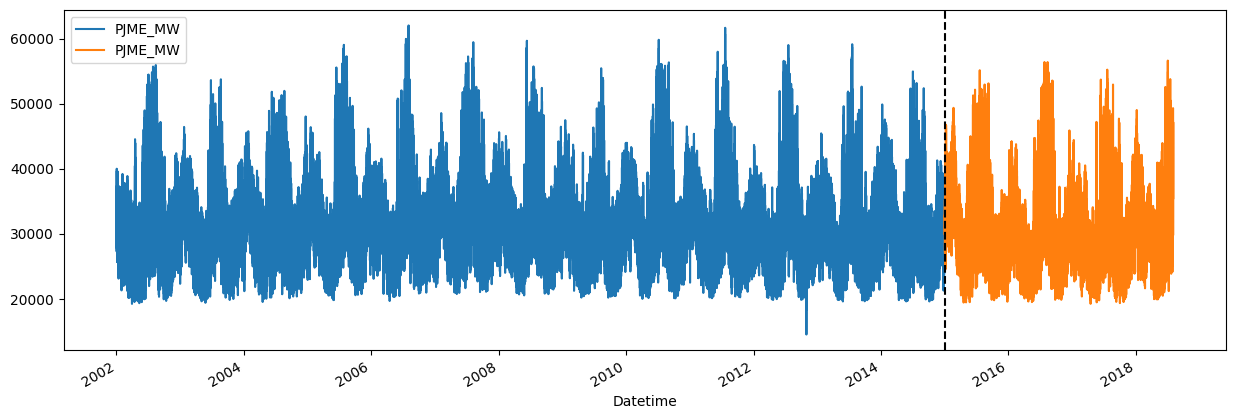

In [10]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
plt.show()

# wow this is incredible [ in awe , wow ]

<function matplotlib.pyplot.show(close=None, block=None)>

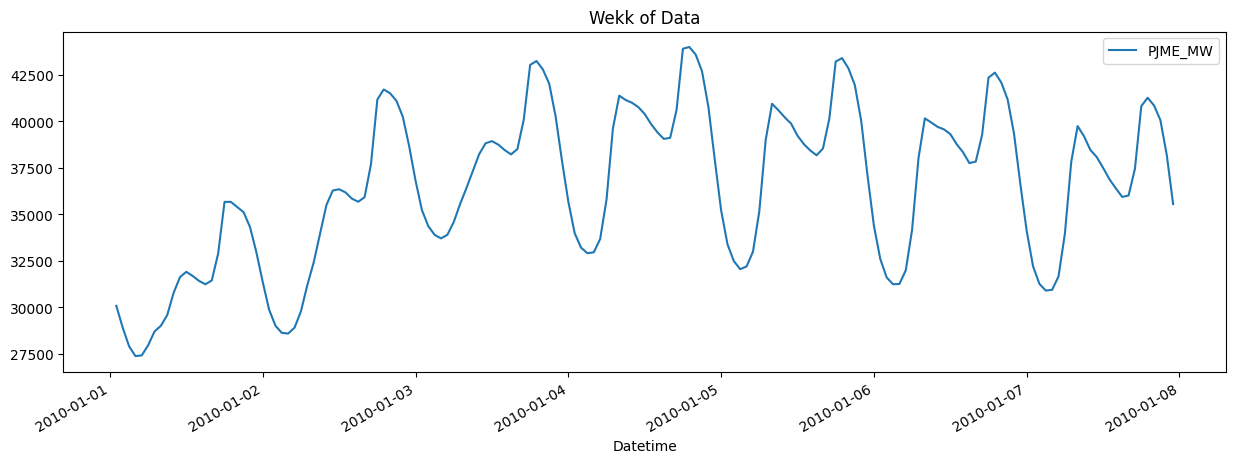

In [12]:
#what , 1 week , of data looks like 
df.loc[(df.index > '01-01-2010') & (df.index <  '01-08-2010')].plot(figsize=(15,5), title='Wekk of Data')
plt.show

# Feature Creation

In [20]:
#pandas makes this very easy for us 

def create_features(df):
    df = df.copy() # so we are editing a copy when run in , test train 
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    #df['dayofmonth'] = df.index.day
    return df
df = create_features(df) # we will run this function , on our dataframe


# Visualize the Features

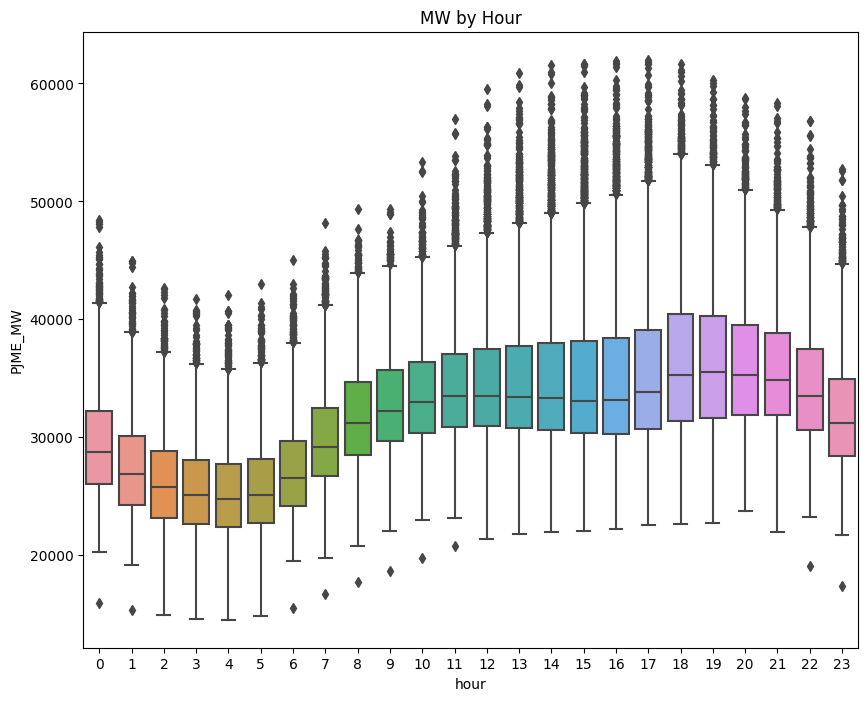

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

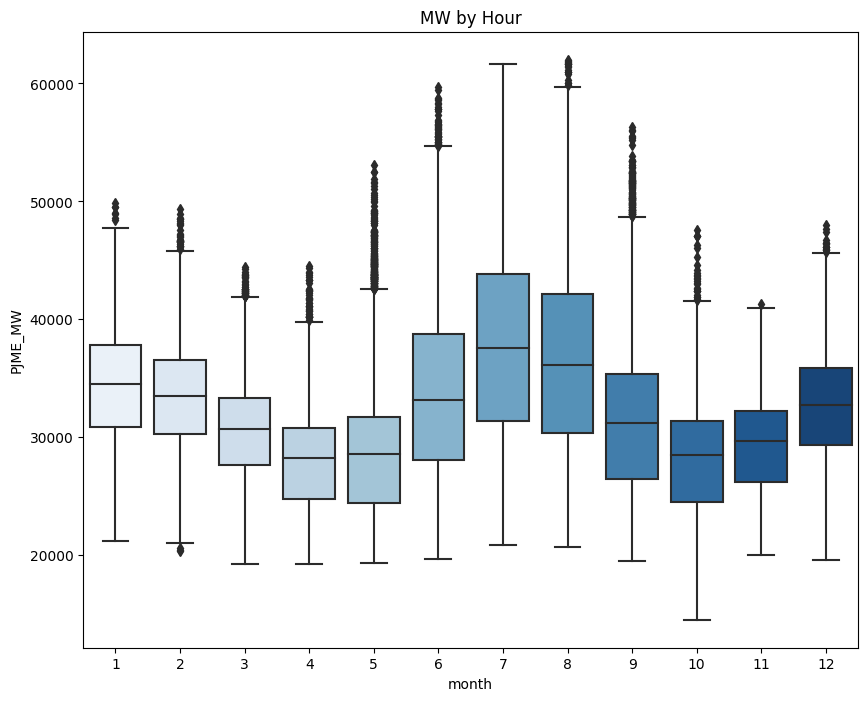

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Hour')
plt.show()

In [ ]:
#peaks in Winter and Summer - month 1 & 7

# Create Model


In [ ]:
#from sklearn.metrics import mean_squared_error
# mean squared, gives strong penality IF waay off , than little bit off 

In [28]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']
TARGET = 'PJME_MW'

x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]



/tmp/ipykernel_32/582852927.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
/tmp/ipykernel_32/582852927.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.day_of_week
/tmp/ipykernel_32/582852927.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [25]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'month', 'quarter', 'year',
       'dayofyear'],
      dtype='object')

In [31]:
#this Regression task

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',n_estimators=1000,
                       early_stopping_rounds=50,objective='reg:linear',max_depth=3,
                       learning_rate=0.01)
    # estimators, number of trees , that will be created 
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)


[13:22:15] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907
[100]	validation_0-rmse:12581.21569	validation_1-rmse:11743.75114
[200]	validation_0-rmse:5835.12466	validation_1-rmse:5365.67709
[300]	validation_0-rmse:3915.75557	validation_1-rmse:4020.67023
[400]	validation_0-rmse:3443.16468	validation_1-rmse:3853.40423
[500]	validation_0-rmse:3285.33804	validation_1-rmse:3805.30176
[600]	validation_0-rmse:3201.92936	validation_1-rmse:3772.44933
[700]	validation_0-rmse:3148.14225	validation_1-rmse:3750.91108
[800]	validation_0-rmse:3109.24248	validation_1-rmse:3733.89713
[900]	validation_0-rmse:3079.40079	validation_1-rmse:3725.61224
[999]	validation_0-rmse:3052.73503	validation_1-rmse:3722.92257


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [ ]:
#14 , overfitting , again 

# Feature Importance

In [32]:
reg.feature_importances_
#gives importance, of each features [ while used in the Trees , in XGBoost model]

array([0.3459163 , 0.187792  , 0.29677063, 0.        , 0.02822942,
       0.14129165], dtype=float32)

In [42]:
fi = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['importance'])
fi

,importance
hour,0.345916
dayofweek,0.187792
month,0.296771
quarter,0.000000
year,0.028229
dayofyear,0.141292


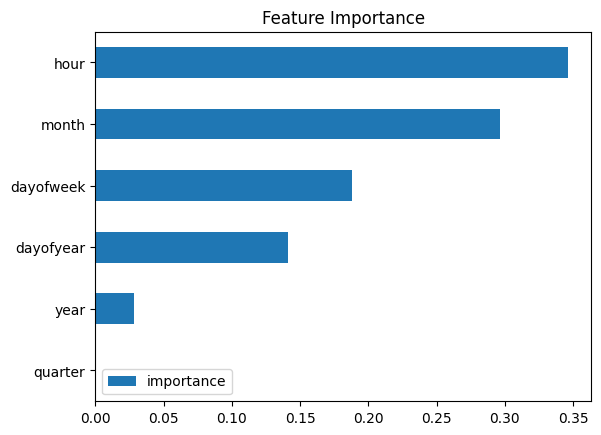

In [41]:

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
# day and month feature , most used by model

# Forcast on Test set 

In [48]:
test['predictions'] = reg.predict(x_test)
test['predictions']

/tmp/ipykernel_32/1035660766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = reg.predict(x_test)


Datetime
2015-01-01 00:00:00    30527.794922
2015-12-31 01:00:00    28238.072266
2015-12-31 02:00:00    27310.228516
2015-12-31 03:00:00    26884.867188
2015-12-31 04:00:00    26884.867188
                           ...     
2018-01-01 20:00:00    36173.695312
2018-01-01 21:00:00    36114.289062
2018-01-01 22:00:00    34566.808594
2018-01-01 23:00:00    32367.011719
2018-01-02 00:00:00    31172.447266
Name: predictions, Length: 31440, dtype: float32

/tmp/ipykernel_32/3617105469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(x_test)


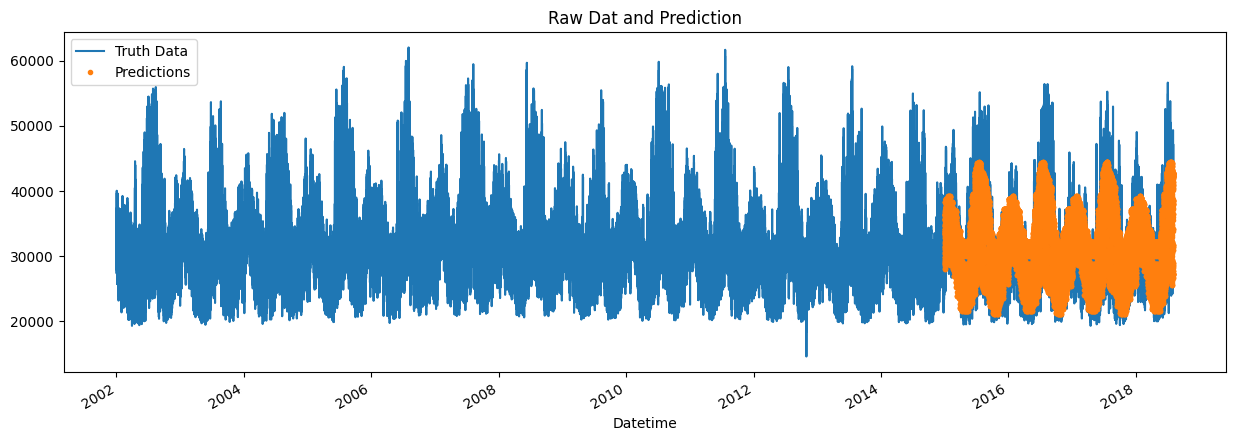

In [51]:
test['prediction'] = reg.predict(x_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

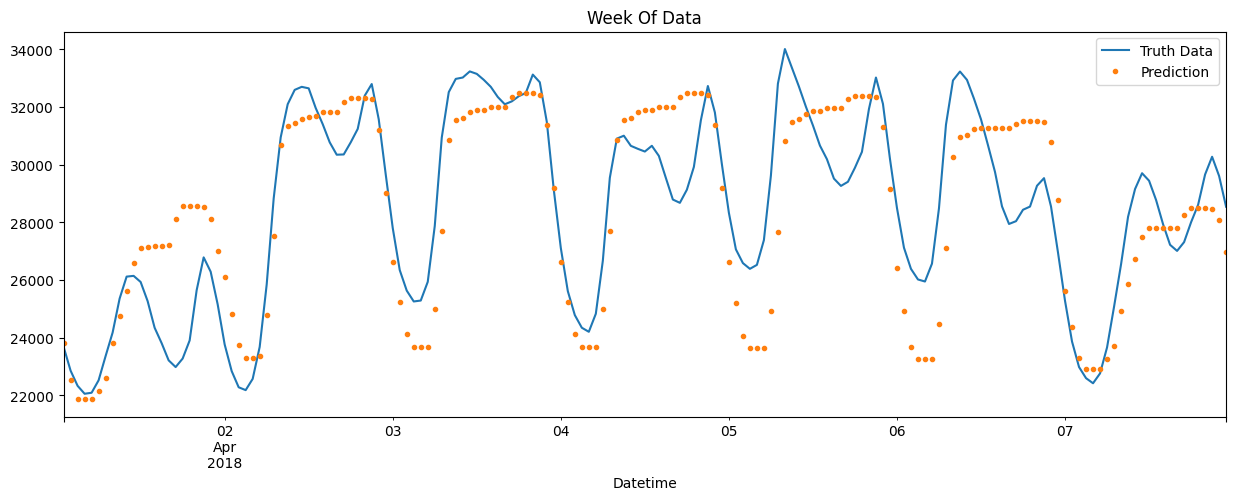

In [52]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [ ]:
# the model could have done better - could have done parameter tuining 


RMSE SCORE 

In [53]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3721.75


Error Calculation [ best and worst predictions

In [54]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12839.597087
2016-08-14    12780.209961
2016-09-10    11356.302979
2015-02-20    10965.982259
2016-09-09    10864.954834
2018-01-06    10506.845622
2016-08-12    10124.051595
2015-02-21     9881.803711
2015-02-16     9781.552246
2018-01-07     9739.144206
Name: error, dtype: float64

In [ ]:
#More robust cross validation
#Add more features (weather forecast, holiday